In [47]:
using Base.Iterators: partition
using BSON
using Flux
using Flux: logitbinarycrossentropy, chunk
using Flux.Data: DataLoader
using Images
using Parameters: @with_kw
using Random
using CUDA
using JSON
using Plots
using DrWatson: struct2dict

device = gpu

const n_patients   = 5366
const DS_PATH      = "../dataset_json/"

"../dataset_json/"

In [48]:
# return list of patients with their trajectories
function load_patients()
    patients = []
    for i = 1:n_patients
        p = JSON.parsefile(DS_PATH * "patient_" * string(i) * ".json")
        push!(patients, p) 
    end
    return patients
end

load_patients (generic function with 1 method)

In [49]:
ps = load_patients();
patients = ps;

In [50]:
function feature_vector(p)
    S, MAP, mortality = p["trajectory"], p["MAP"], p["mortality"]
    return [convert(Array{Float32}, [S[i]; MAP[i] / 50.0]) for i=1:length(S)]
end

function target_vector(p)
    S, MAP, mortality = p["trajectory"], p["MAP"], p["mortality"]
    return [MAP[i] * (mortality ? -1 : 1) for i=1:length(S)]
end

target_vector (generic function with 1 method)

In [51]:

# load MNIST images and return loader
function get_data(batch_size, ps)
    p_m     = length(ps)
    m       = 0
    x_train = []
    y_train = []
    for i=1:p_m
        pd = hcat(feature_vector(ps[i])...)
        push!(x_train, pd)
        m += size(pd)[2]
        push!(y_train, vcat(target_vector(ps[i])...))
         
    end
    x_train = hcat(x_train...)
    y_train = vcat(y_train...)
    
    println(size(x_train))
    println(size(y_train))
    
    DataLoader(x_train, y_train, batchsize = batch_size, shuffle = true)
end

get_data (generic function with 1 method)

In [52]:
loader = get_data(512, ps);

(50, 352328)
(352328,)


In [53]:
loader.data[2]

352328-element Array{Float64,1}:
 -83.0
 -84.5
 -68.2
 -69.33333333333333
 -70.0
 -73.0
 -66.0
 -68.0
 -71.0
 -72.0
 -80.0
 -77.0
 -79.0
   ⋮
  93.0
   8.0
  85.3332977294922
  85.3332977294922
  85.3332977294922
  91.6667022705078
  86.0
  86.0
  81.6667022705078
  82.0
  78.3332977294922
  75.0

In [54]:
struct Encoder
    linear
    μ
    logσ
    Encoder(input_dim, latent_dim, hidden_dim, device) = new(
        Chain(
            Dense(input_dim, hidden_dim, Flux.relu), 
            Dense(hidden_dim, hidden_dim, Flux.relu)) |> device,   # linear
        Dense(hidden_dim, latent_dim) |> device,        # μ
        Dense(hidden_dim, latent_dim) |> device,        # logσ
    )
end

In [55]:
function (encoder::Encoder)(x)
    h = encoder.linear(x)
    encoder.μ(h), encoder.logσ(h)
end

Decoder(input_dim, latent_dim, hidden_dim, device) = Chain(
    Dense(latent_dim, hidden_dim, Flux.relu),
    Dense(hidden_dim, hidden_dim, Flux.relu),
    Dense(hidden_dim, input_dim)
) |> device


Decoder (generic function with 1 method)

In [86]:

function model_loss(encoder, decoder, λ, x, device)
    μ, logσ, decoder_z = reconstuct(encoder, decoder, x, device)
    len = size(x)[end]
    
    latent_loss     = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ)) / len
    generation_loss = sum(Flux.Losses.mse.(decoder_z, x)) / len
    reg             = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    return latent_loss + generation_loss + reg
end

model_loss (generic function with 1 method)

In [87]:
# arguments for the `train` function 
@with_kw mutable struct Args
    η = 1e-5                # learning rate
    λ = 0.01f0             # regularization paramater
    batch_size = 512        # batch size
    sample_size = 10        # sampling size for output    
    epochs = 20             # number of epochs
    seed = 0                # random seed
    cuda = true             # use GPU
    input_dim = 50          # image size
    latent_dim = 3          # latent dimension
    hidden_dim = 400        # hidden dimensions
    verbose_freq = 1000     # logging for every verbose_freq iterations
    tblogger = false        # log training with tensorboard
    save_path = "output"    # results path
end

Args

In [88]:
args = Args()

Args
  η: Float64 1.0e-5
  λ: Float32 0.01f0
  batch_size: Int64 512
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 50
  latent_dim: Int64 3
  hidden_dim: Int64 400
  verbose_freq: Int64 1000
  tblogger: Bool false
  save_path: String "output"


In [89]:
println("Initializing VAE model...")
encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim, device)
decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim, device)

# ADAM optimizer
opt = ADAM(args.η)
    
# parameters
ps = Flux.params(encoder.linear, encoder.μ, encoder.logσ, decoder)

Initializing VAE model...


Params([Float32[0.062373426 -0.06477717 … -0.0014846489 0.028679922; -0.00060024107 -0.053941913 … -0.036201145 -0.011662153; … ; 0.07331024 0.09015352 … -0.06317078 -0.09003806; 0.017344855 -0.09885059 … 0.040184796 -0.039154314], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.029574214 0.008178453 … 0.0078325635 0.05537858; -0.039101124 -0.08161739 … 0.027518947 -0.023904925; … ; 0.033608064 0.0081998445 … -0.014474955 -0.074270725; -0.02741073 0.02728893 … 0.048167363 0.07987661], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.11092357 -0.010114174 … 0.10807885 0.040392667; 0.032868404 -0.08067249 … -0.031044437 -0.055309843; 0.052571304 -0.0043575866 … -0.10111806 -0.027787812], Float32[0.0, 0.0, 0.0], Float32[0.107463606 0.044171248 … -0.0811927 0.045296937; -0.11811463 0.0683129 … 0.08848173 0.07007598; -0.015255277 -0.10859395 … 

In [90]:
!ispath(args.save_path) && mkpath(args.save_path)

false

In [91]:
function reconstuct(encoder, decoder, x, device)
    μ, logσ = encoder(x)
    z = μ + device(randn(Float32, size(logσ))) .* exp.(logσ)
    μ, logσ, decoder(z)
end

reconstuct (generic function with 1 method)

In [92]:
train_steps  = 0
train_losses = []
for epoch = 1:args.epochs
    print("\nEpoch $(epoch)")
    loss = 0.0

    for (x, _) in loader 
        loss, back = Flux.pullback(ps) do
            model_loss(encoder, decoder, args.λ, x |> device, device)
        end
        
        grad = back(1f0)
        Flux.Optimise.update!(opt, ps, grad)

        if train_steps % 25 == 1
            print(".")
            push!(train_losses, loss)
        end

        train_steps += 1
    end
    
    println("loss:", loss)
end


Epoch 1............................loss:12.039766

Epoch 2............................loss:11.645294

Epoch 3...........................loss:10.672046

Epoch 4............................loss:10.171997

Epoch 5...........................loss:10.093215

Epoch 6............................loss:9.741862

Epoch 7...........................loss:9.454929

Epoch 8............................loss:9.60338

Epoch 9...........................loss:8.728943

Epoch 10............................loss:8.765682

Epoch 11............................loss:8.829334

Epoch 12...........................loss:8.639367

Epoch 13............................loss:9.23006

Epoch 14...........................loss:7.516266

Epoch 15............................loss:8.420184

Epoch 16...........................loss:8.34293

Epoch 17............................loss:8.501148

Epoch 18............................loss:8.195087

Epoch 19...........................loss:8.066024

Epoch 20............................loss:8.02

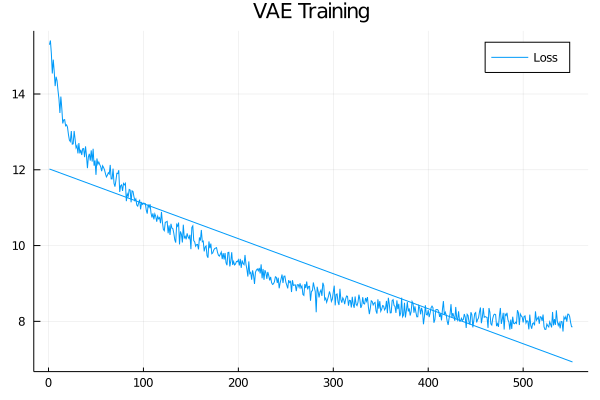

In [93]:
plot(1:length(train_losses), train_losses, title = "VAE Training", label = "Loss", smooth = true)

In [94]:
reconstuct(encoder, decoder, feature_vector(patients[1])[1] |> device, device)[3]

50-element CuArray{Float32,1}:
  0.012629844
  0.040055625
 -0.08920178
 -0.18235661
 -0.18940571
 -0.13852443
 -0.17099303
 -0.083830275
 -0.015514525
  0.13317233
  0.11863153
 -0.013514372
 -0.021742757
  ⋮
  0.0882954
 -0.21877015
  0.12527575
  0.1295368
  0.12765913
 -0.17785338
 -0.17684262
 -0.17049398
 -0.07573278
 -0.07390445
 -0.072644286
  1.551424

In [95]:
feature_vector(patients[1])[1]

50-element Array{Float32,1}:
 -0.35948172
  0.43990737
 -1.0590913
 -0.48791927
 -0.1743005
 -0.14888796
 -0.13654973
 -0.61029875
 -0.24194391
  0.28084475
  0.15390423
 -0.06261549
 -0.1839509
  ⋮
  0.22211784
 -0.108395904
  0.28033373
  0.2831705
  0.2850545
  0.34823036
  0.34936163
  0.35055524
 -0.5739797
 -0.56734794
 -0.56106305
  1.66

In [96]:
# save model
model_path = joinpath(args.save_path, "model.bson") 
let encoder = cpu(encoder), decoder = cpu(decoder), args=struct2dict(args)
    BSON.@save model_path encoder decoder args
    @info "Model saved: $(model_path)"
end

┌ Info: Model saved: output/model.bson
└ @ Main In[96]:5


In [97]:
function plot_result(loader, centers = nothing)
    
    BSON.@load "output/model.bson" encoder decoder args
    
    device = args[:cuda] ? gpu : cpu
    encoder, decoder = encoder |> device, decoder |> device
    
    #
    # clustering in the latent space
    # visualize first two dims
    #
    plt = scatter3d(palette=:rainbow)
    
    function get_color(y)
        if y < 0
            v = abs(y)
            if v > 65
                return :blue
            else
                return :red
            end    
        else
            if y > 65
                return :green
            else
                return :yellow
            end
        end
    end
    
    for (i, (x, y)) in enumerate(loader)
        
        i < 40 || break
        
        μ, logσ = encoder(x |> device) |> cpu
        
        colors = [get_color(v) for v in y]
        
        scatter3d!(μ[1, :], μ[2, :], μ[3, :], 
            markerstrokewidth = 0, 
            markeralpha = 0.5,
            markersize = 2,
            aspect_ratio = 1,
            markercolor = colors, 
            label = "")
    end
    
    if !isnothing(centers)
        scatter3d!(centers[1, :], centers[2, :], centers[3, :],
            markerstrokewidth = 1, 
            markersize = 3,
            aspect_ratio = 1,
            stroke = :black,
            markercolor = :white, 
            label = "")
    end
    
    savefig(plt, "output/clustering.png")
    display(plt)
    
end

plot_result (generic function with 2 methods)

In [98]:
plot_result(loader)

In [99]:
args

Args
  η: Float64 1.0e-5
  λ: Float32 0.01f0
  batch_size: Int64 512
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 50
  latent_dim: Int64 3
  hidden_dim: Int64 400
  verbose_freq: Int64 1000
  tblogger: Bool false
  save_path: String "output"


In [100]:
include("../state_cluster/state_utils.jl")

load_patients (generic function with 1 method)

In [101]:
states2d = []
for (i, (x, y)) in enumerate(loader)
    μ, logσ = encoder(x |> device)
    push!(states2d, μ)
end
S₂ = hcat(states2d...) |> cpu

3×352328 Array{Float32,2}:
 0.624534   -1.41648    -0.64281     …  -0.133397   -0.392681   -0.351082
 0.0116095   0.0472508   0.00776354      0.0113334   0.0222259   0.0521648
 0.0675902  -0.470926    0.39798         0.152811    0.0362855  -0.0821608

In [102]:
clusters = k_means_pp(S₂[:,1:50000], n_states);

k_means_pp 1 of 750
k_means_pp 11 of 750
k_means_pp 21 of 750
k_means_pp 31 of 750
k_means_pp 41 of 750
k_means_pp 51 of 750
k_means_pp 61 of 750
k_means_pp 71 of 750
k_means_pp 81 of 750
k_means_pp 91 of 750
k_means_pp 101 of 750
k_means_pp 111 of 750
k_means_pp 121 of 750
k_means_pp 131 of 750
k_means_pp 141 of 750
k_means_pp 151 of 750
k_means_pp 161 of 750
k_means_pp 171 of 750
k_means_pp 181 of 750
k_means_pp 191 of 750
k_means_pp 201 of 750
k_means_pp 211 of 750
k_means_pp 221 of 750
k_means_pp 231 of 750
k_means_pp 241 of 750
k_means_pp 251 of 750
k_means_pp 261 of 750
k_means_pp 271 of 750
k_means_pp 281 of 750
k_means_pp 291 of 750
k_means_pp 301 of 750
k_means_pp 311 of 750
k_means_pp 321 of 750
k_means_pp 331 of 750
k_means_pp 341 of 750
k_means_pp 351 of 750
k_means_pp 361 of 750
k_means_pp 371 of 750
k_means_pp 381 of 750
k_means_pp 391 of 750
k_means_pp 401 of 750
k_means_pp 411 of 750
k_means_pp 421 of 750
k_means_pp 431 of 750
k_means_pp 441 of 750
k_means_pp 451 of 750

In [103]:
# now we call standard k-means
m_centroids = hcat(clusters...)
R           = kmeans!(S₂, m_centroids)

KmeansResult{Array{Float32,2},Float32,Int64}(Float32[0.22384919 -0.65728563 … -0.98673534 -1.2479972; 0.0066958326 -0.14289054 … -0.0014791738 -0.045611262; 0.044056114 -3.8378181 … -0.269267 -1.2769368], [478, 482, 736, 123, 335, 550, 44, 458, 732, 31  …  323, 396, 525, 333, 352, 222, 440, 331, 396, 514], Float32[0.0018259287, 0.005214691, 0.0022124052, 0.0005313754, 0.005025625, 0.0024347305, 0.00083339214, 0.0002962947, 0.0026919842, 0.0026240349  …  0.0022390783, 0.0041490495, 0.0025877953, 0.0018924475, 0.0008277297, 0.0058698654, 0.0060596466, 0.003205739, 0.00024077296, 0.003042072], [2035, 18, 9, 103, 44, 16, 20, 163, 26, 355  …  556, 73, 114, 91, 15, 145, 144, 1527, 377, 120], [2040, 18, 9, 103, 43, 16, 20, 163, 26, 348  …  556, 73, 114, 91, 15, 145, 144, 1528, 376, 120], 1057.3303f0, 100, false)

In [104]:
centers = R.centers

3×750 Array{Float32,2}:
 0.223849    -0.657286  -3.44436    …  0.70883    -0.986735    -1.248
 0.00669583  -0.142891  -0.0329862     0.0118174  -0.00147917  -0.0456113
 0.0440561   -3.83782   -0.4092        0.268485   -0.269267    -1.27694

In [105]:
plot_result(loader, centers)

In [106]:
state_vectors_file = apath * "state_vectors_vae2.json" 
save_state_vectors(state_vectors_file, centers)

In [107]:
lvc = restore_state_vectors(state_vectors_file)

3×750 Array{Float64,2}:
 0.223849    -0.657286  -3.44436    …  0.70883    -0.986735    -1.248
 0.00669583  -0.142891  -0.0329862     0.0118174  -0.00147917  -0.0456113
 0.0440561   -3.83782   -0.4092        0.268485   -0.269267    -1.27694

In [108]:
# after save-restore matrices should be the almost the same
centers ≈ lvc

true

In [109]:
function get_vae_states(p)
    fv = feature_vector(p)
    X = hcat(fv...)
    μ, logσ = encoder(X |> device)
    return μ, logσ
end

get_vae_states (generic function with 1 method)

In [110]:
function find_center(state, C)
    state_ids = []
    d         = Float64(Inf)
    idx       = -1
    dims      = size(state)[1]
    
    for k = 1:n_states
        d_k = distance(state, C[:, k], dims)
        if d_k < d
            d = d_k
            idx = k
        end
    end
    
    return idx
end

find_center (generic function with 1 method)

In [113]:
apath = "../dataset_artifacts_vae/"

for pid = 1:n_patients
    p       = patients[pid]
    tr, _   = get_vae_states(p) |> cpu
    tr_len  = size(tr)[2] 

    states  = [find_center(tr[:,i], centers) for i=1:tr_len]
    rewards = [0.0 for i=1:tr_len]
    
    if p["mortality"]
        push!(states, STATE_DECEASED)
        rewards[end - 1] = -1.0
        rewards[end]     = -1.0
    else
        push!(states, STATE_SURVIVED)
        rewards[end - 1] = 0
        rewards[end]     = 0
    end    

    mdp_p = Dict()
    mdp_p["trajectory"]      = states
    mdp_p["rewards"]         = rewards
    mdp_p["actions"]         = p["actions"]
    mdp_p["cont_actions"]    = p["cont_actions"]
    mdp_p["cont_trajectory"] = p["trajectory"]
    mdp_p["MAP"]             = p["MAP"]
    
    if pid % 100 == 1
        print(".")
    end
    
    json_mdp_p = JSON.json(mdp_p)
    filename   = apath * "mdp_patient_" * string(pid) * ".json"

    open(filename, "w") do io
       println(io, json_mdp_p)
    end
end


......................................................